# Computer vision

> Using the fastai library in computer vision.

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [ ]:
# all_slow

This tutorial highlights how quickly build a `Learner` and finetune a pretrained model on most computer vision tasks. 

## Single-label classification

For this task, we will use the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) that contains images of cats and dogs of 37 different breeds. We will first show how to build a simple cat-vs-dog classifier, then a little bit more advanced models that can classify all breeds.

The dataset can be downloaded and decompressed with this line of code:

In [ ]:
path = untar_data(URLs.PETS)

It will only do this download once, and return the location of the decompressed archive. We can check what is inside with the `.ls()` method.

In [ ]:
path.ls()

(#2) [Path('/home/sgugger/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/sgugger/.fastai/data/oxford-iiit-pet/images')]

We will ignore the annotations folder for now, and focus on the images one. `get_image_files` is a fastai function that helps us grab all the image files (recursively) in one folder.

In [ ]:
files = get_image_files(path/"images")
len(files)

7390

### Cats vs dogs

To label our data for the cats vs dogs problem, we need to know which filenames are of dog pictures and which ones are of cat pictures. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dog:

In [ ]:
files[0],files[6]

(Path('/home/sgugger/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_187.jpg'),
 Path('/home/sgugger/.fastai/data/oxford-iiit-pet/images/Ragdoll_138.jpg'))

We can then define an easy label function:

In [ ]:
def label_func(f): return f[0].isupper()

To get our data ready for a model, we need to put it in a `DataLoaders` object. Here we have a function that labels using the file names, so we will use `ImageDataLoaders.from_name_func`. There are other factory methods of `ImageDataLoaders` that could be more suitable for your problem, so make sure to check them all in `vision.data`. 

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

We have passed to this function the directory we're working in, the `files` we grabbed, our `label_func` and one last piece as `item_tfms`: this is a `Transform` applied on all items of our datasets that will resize each imge to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn't pass this, we would get an error later as it would impossible to batch the items together.

We can then check everything looks okay with the `show_batch` method (`True` is for cat, `False` is for dog):

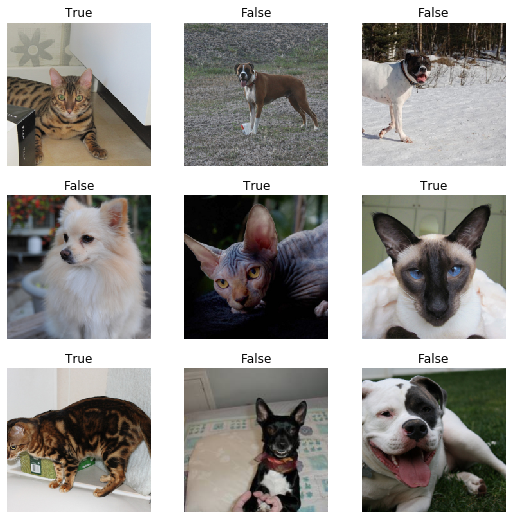

In [ ]:
dls.show_batch()

Then we can create a `Learner`, which is a fastai object that combines data and model for training, and use transfer learning to finetune a pretrained model in just two lines of codes:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

The first line downloaded a model called ResNet34, pretrained on [ImageNet](http://www.image-net.org/), and adapted it to our specific problem. It then finetuned that model and in a relatively short time, we get a model with an error rate of 0.3%... amazing!

If you want to make a prediction on a new image, you can use `learn.predict`:

In [ ]:
learn.predict(files[0])

('False', tensor(0), tensor([1.0000e+00, 1.3964e-08]))

The predict method returns three things: the decoded prediction (here `False` for dog), the index of the predicted class and the tensor of probabilities that our image is one of a dog (here the model is quite confident!) This method accepts a filename, a PIL image or a tensor directly in this case.

We can also have a look at some predictions with the `show_results` method:

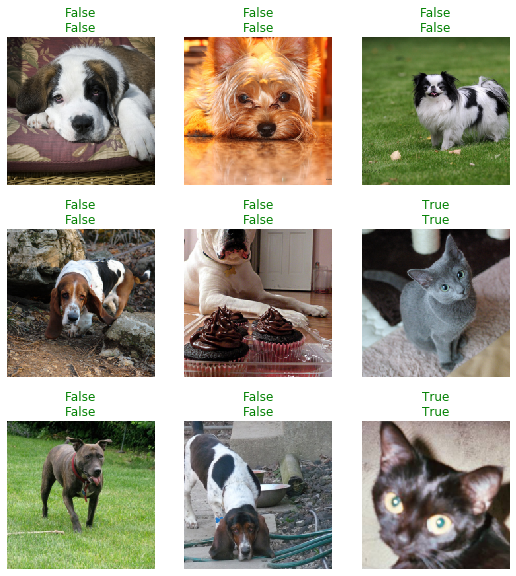

In [ ]:
learn.show_results()

Check out the other applications like text or tabular, or the other problems covered in this tutorial, and you will see they all share a consistent API for gathering the data and look at it, create a `Learner`, train the model and look at some predictions.

### Classifying breeds

To label our data with the breed name, we will use a regular expression to exctract it from the filename. Looking back at a filename, we have:

In [ ]:
files[0].name

'yorkshire_terrier_187.jpg'

so the class is everything before the last `_` followed by some digits. A regular expression that will catch the name is thus:

In [ ]:
pat = r'^(.*)_\d+.jpg'

Since it's pretty common to use regular expressions to label the data (often, labels are hidden in the file names), there is a factory method to do just that:

In [ ]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

Like before, we can then use `show_batch` to have a look at our data:

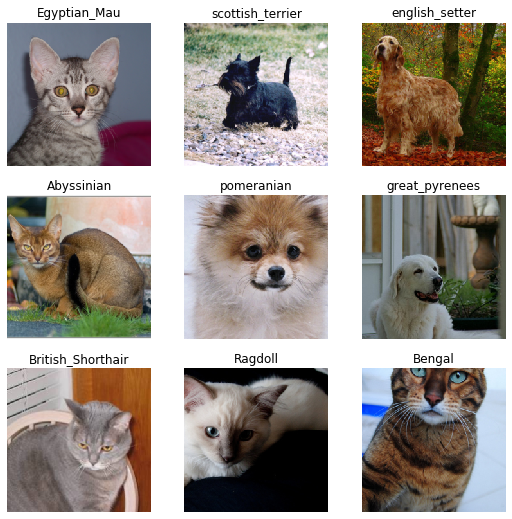

In [ ]:
dls.show_batch()

Since classifying the exact breed of cats or dogs amongst 37 different breeds is a harder problem, we will slightly change the definition of our `DataLoaders` to use data augmentation:

In [ ]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

This time we resized to a larger size before batching, and we add `batch_tfms`. `aug_transforms` is a function that provides a collection of data augmentation transforms with default we found worked very well on most datasets (you can customize everyone by passing the right arguments).

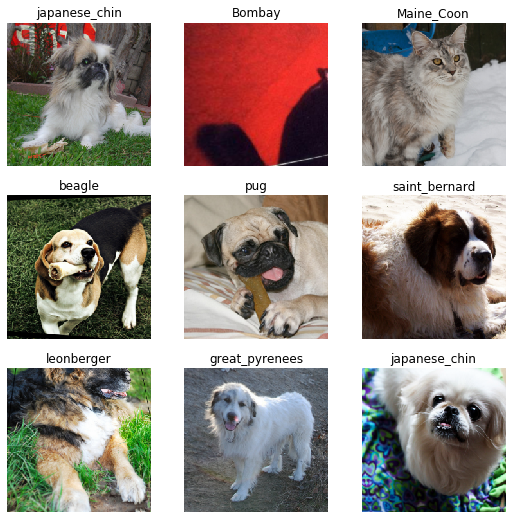

In [ ]:
dls.show_batch()

We can then create our `Learner` exactly as before and train our model.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

We used the default learning rate before, but we might want to find the best one possible. For this, we can use the learning rate finder:

(0.010000000149011612, 0.00363078061491251)

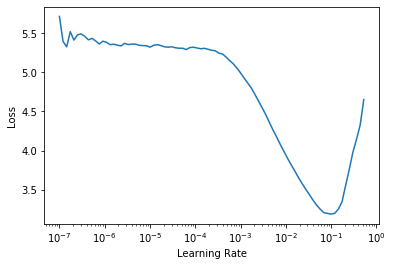

In [ ]:
learn.lr_find()

It plots the graph of the learning rate finder and gives us two suggestions (minimum divided by 10 and steepest gradient). Let's use `3e-3` here. We will also do a bit more epochs than just 1 and 1. Let's do 4 frozen epochs (where the pretrained model is frozen and we only train the head we added for our custom problem) and 2 unfrozen. 

Instead of using `fine_tune`, we will show you how to do this manually:

In [ ]:
learn.fit_one_cycle(4, 3e-3)

Now we can unfreeze the model and train it a bit more. We pass a slice for the learning rate, to apply discriminative learning rates: the deepest part of the model will be trained at the lowest learning rate provided and the head at the highest learning rate.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-5, 1e-3))

Again, we can have a look at some predictions with `show_results`:

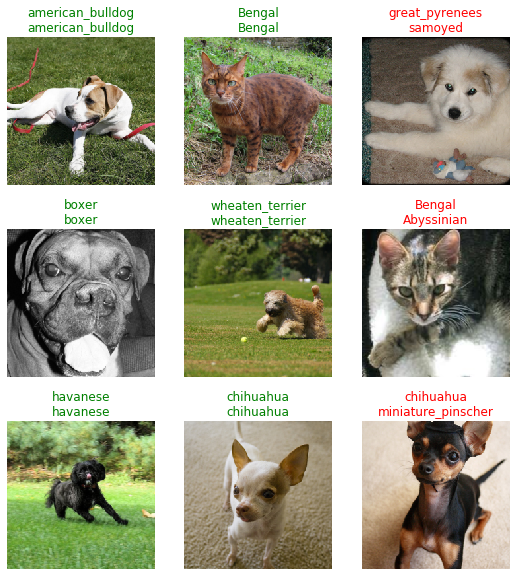

In [ ]:
learn.show_results()

Another thing that is useful is an interpretation object, that can show us where the model made the worse predictions:

In [ ]:
interp = Interpretation.from_learner(learn)

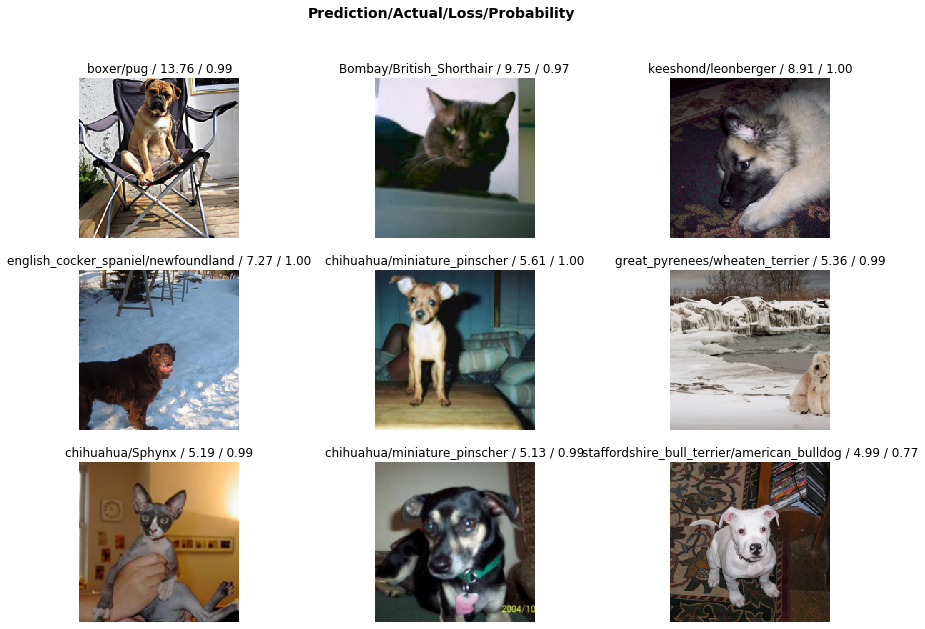

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

### With the data block API

We can also use the data block API to get our data in a `DataLoaders`. This is a bit more advanced, so fell free to skip this part if you are not comfortable with new APIs to learn jsut yet.

A datablock is built by giving the fastai library a bunch of informations:

- the types used, through an argument called `blocks`: here we have images and categories, so we pass `ImageBlock` and `CategoryBlock`.
- how to get the raw items, here our function `get_image_files`.
- how to label those items, here with the same regular expression as before.
- the `item_tfms` and `batch_tfms` like before.

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

The pets object by itself is empty: it only containes the functions that will help us gather the data. We have to call `dataloaders` method to get a `DataLoaders`. We pass it the source of the data:

In [ ]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")

Then we can look at some of our pictures with `dls.show_batch()`

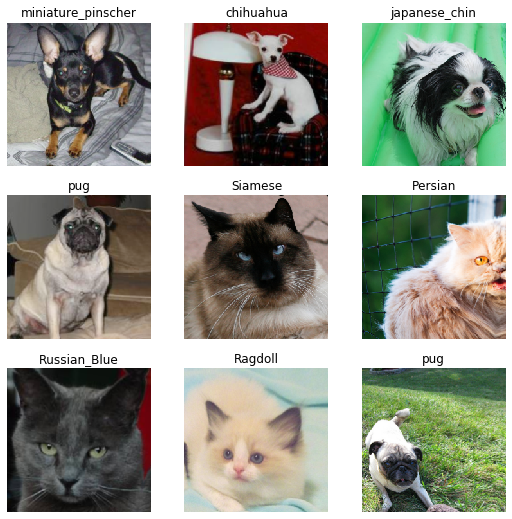

In [ ]:
dls.show_batch(max_n=9)

In [ ]:
learn1.show_results(max_n=9)

In [ ]:
interp = Interpretation.from_learner(learn1)

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

## Multi-label classification

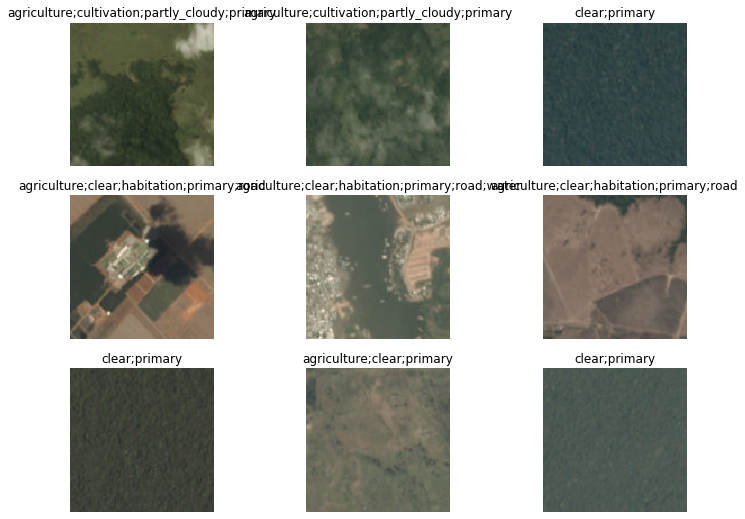

In [ ]:
planet_source = untar_data(URLs.PLANET_TINY)
df = pd.read_csv(planet_source/"labels.csv")

planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=lambda x:planet_source/"train"/f'{x[0]}.jpg',
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1].split(' '),
                   batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

dls = planet.dataloaders(df.values)
dls.show_batch(max_n=9, figsize=(12,9))

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy_multi)
learn.fit_one_cycle(1)

In [ ]:
learn.predict(planet_source/f'train/train_10030.jpg')

((#5) ['bare_ground','clear','cloudy','cultivation','road'],
 tensor([False, False,  True, False,  True,  True,  True, False, False, False,
         False,  True, False, False]),
 tensor([0.4993, 0.2256, 0.6531, 0.3821, 0.7002, 0.6430, 0.6785, 0.4854, 0.2270,
         0.4699, 0.4722, 0.7407, 0.1130, 0.1830]))

In [ ]:
learn.tta(use_max=True)

In [ ]:
img = PILImage.create(planet_source/f'train/train_10030.jpg')

In [ ]:
learn.predict(img)

In [ ]:
learn.show_results(max_n=9)

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9)

## Segmentation

In [ ]:
codes = np.loadtxt(untar_data(URLs.CAMVID_TINY)/'codes.txt', dtype=str)
def get_y(o): return path/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   batch_tfms=aug_transforms())
dls = camvid.dataloaders(path/"images", bs=8)

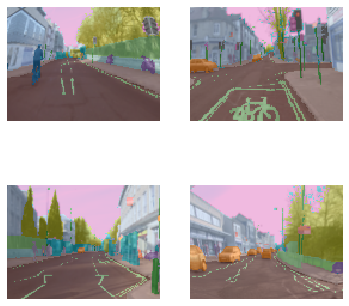

In [ ]:
dls.show_batch(max_n=4)

In [ ]:
learn = unet_learner(dls, resnet34)
# learn.fine_tune(1, 1e-3)
# Use the below to get somewhat reasonable results - but takes a bit longer
learn.fine_tune(8)

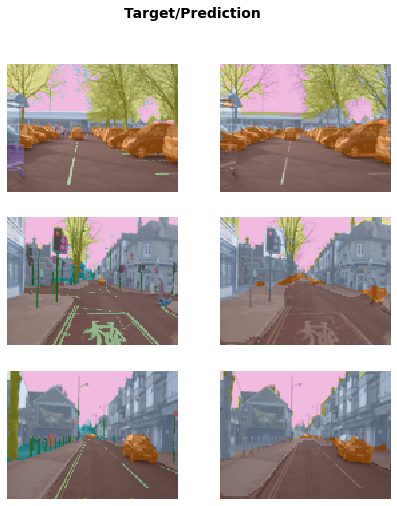

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

## Points

In [ ]:
path = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = (path/'centers.pkl').load()

In [ ]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items = get_image_files,
                 get_y = lambda o:fn2ctr[o.name].flip(0),
                 splitter=RandomSplitter(),
                 batch_tfms=[*aug_transforms(size=(120,160)), Normalize.from_stats(*imagenet_stats)])

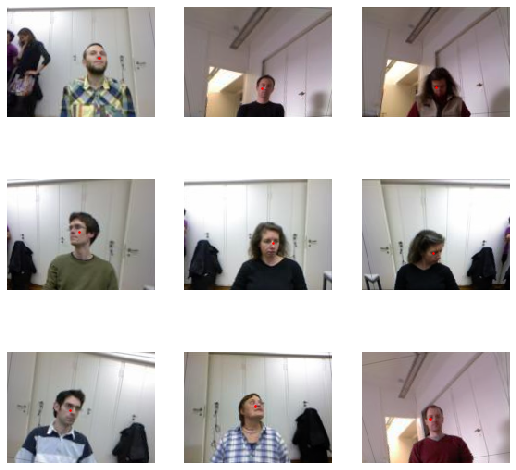

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, vmin=1, vmax=30)

In [ ]:
#TODO: look for attrs in after_item
dls.c = dls.after_item.c
dls.train_ds.loss_func = MSELossFlat()

In [ ]:
learn = cnn_learner(dls, resnet34)
learn.fit_one_cycle(3, 1e-3)

In [ ]:
learn.predict(dls.train_ds.items[0])

(tensor([[ 13.2822, 167.8245]]),
 tensor([-0.8340,  1.7971]),
 tensor([-0.8340,  1.7971]))

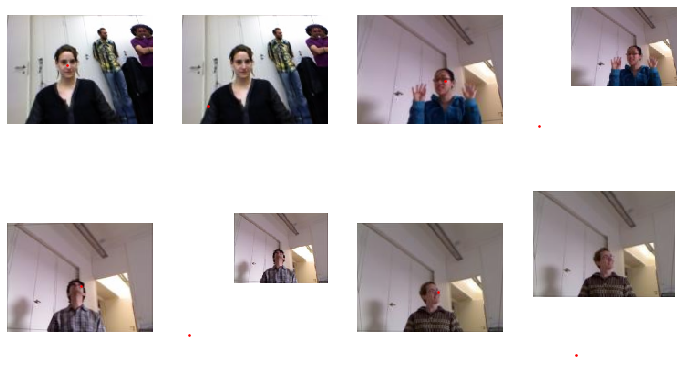

In [ ]:
learn.show_results(max_n=4)

## fin